# K-Fold Cross Validation for Multi-Class Classification using ULMFit

Classifying the sentences from IRs (Instruction Reports) into different labels of "Human Errors" i.e.: <Br>
T: Team Cognition <br>
P: Procedural <br>
O: Organizational <br>
D: Design <br>
H: Human <br>
<br>
For Training Data, we have sentences labelled by the coders - Sally, Frenard and Trixy <BR>
<br>
The coders have also labelled sentences as 'U': useless


## 1. Configuring GPU

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## 2. Import the Data


In [0]:
df = []

files = [f for f in glob.glob("*.csv")]
df_raw = pd.DataFrame()

for file in files:
 
  df = pd.read_csv(file)
  df['text'] = df['text'].apply(str)
  df_raw = pd.concat([df_raw , df], ignore_index=True)

df = df_raw.dropna()
df.head()

,label_SALLY,text,line,start_pos,end_pos,file,label_struck
0,U,"May 15, 2007 Kevin Walsh Vice President Operations Waterford 3 Entergy Operations, Inc. 17265 River Road Killona, LA 70066-0751 SUBJECT: WATERFORD STEAM ELECTRIC STATION, UNIT 3 - NRC INTEGRATED INSPECTION REPORT 05000382/2007002 Dear Mr. Walsh: On April 7, 2007, the NRC completed an inspection at your Waterford Steam Electric Station, Unit 3.",0,0,345,ML071350662.txt,U
1,U,"The enclosed report documents the inspection findings, which were discussed on April 5, 2007, with you and other members of your staff.",0,345,480,ML071350662.txt,U
2,U,This inspection examined activities conducted under your license as they relate to safety and compliance with the Commission's rules and regulations and with the conditions of your license.,0,480,669,ML071350662.txt,U
3,U,"The inspectors reviewed selected procedures and records, observed activities, and interviewed personnel.",0,669,773,ML071350662.txt,U
4,U,This report documents two findings of very low safety significance (Green).,0,773,848,ML071350662.txt,U


## 3. Data Preprocessing


In [0]:
# Get labels of these coders
TRAINING_LABEL = ['label_SALLY','label_struck']

# Get labels of sentences, which were labelled same by the coders (excluding 'U')
def get_similar(row):
    if len(TRAINING_LABEL)==2:
        if row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] and row[TRAINING_LABEL[0]] != 'U':
            return row[TRAINING_LABEL[0]]
        else:
            return np.NaN
    if len(TRAINING_LABEL)==3:
        if row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] == row[TRAINING_LABEL[2]] and row[TRAINING_LABEL[0]] != 'U':
            return row[TRAINING_LABEL[0]]
        else:
            return np.NaN

# Get labels of sentences, which were labelled different by the coders (excluding 'U')
def get_different(row):
    if len(TRAINING_LABEL) == 2:
        if row[TRAINING_LABEL[0]] == 'U' or row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]]:
            return np.NaN
        else:
            return row[TRAINING_LABEL[0]]
    if len(TRAINING_LABEL) == 3:
        if row[TRAINING_LABEL[0]] == 'U' or row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] == row[TRAINING_LABEL[2]]:
            return np.NaN
        else:
            return row[TRAINING_LABEL[0]]

# Get label of a sentence (first label if there are multiple labels)
# Get NULL if the label is 'U'
def class_label_handler(class_label):
  if 'U' in class_label:
    return np.NaN
  else:
    return class_label.split(',')[0]

for label in TRAINING_LABEL:  
  df[label] = df[label].apply(class_label_handler)

if len(TRAINING_LABEL) > 1:
  df['Y'] = df.apply(get_similar, axis=1)
else:
  df['Y'] = df[TRAINING_LABEL]

# Drop rows with NULL labels
for label in TRAINING_LABEL:
  df = df.drop(label, axis=1)
  
df = df.dropna()

'''
label_idx = {'T':0, 'P': 1, 'O': 2, 'D': 3, 'H': 4}
def changing_labels_to_integers(class_label):
  return label_idx[class_label]

df['Y']=df['Y'].apply(changing_labels_to_integers)
'''
print(len(df['Y']))

df.head()

144


,text,line,start_pos,end_pos,file,Y
39,"The inspectors identified a Green noncited violation of 10 CFR 50 Appendix B, Criterion III, ""Design Control,"" for failure to assure that the design basis, as specified in the license application, was correctly translated into drawings and the actual plant configuration.",31,869,1140,ML071350662.txt,D
42,"Current plant configuration and Drawing G-499 S06, ""Common Foundation Structure, Masonry,"" Sheet 6, do not conform to the design basis, in that there are no openings other than the floor drains.",31,1482,1676,ML071350662.txt,D
52,The inspectors identified a finding of very low safety significance for failure to assure that the design basis for the dry cooling tower diesel-driven sump pumps was properly implemented.,39,6,194,ML071350662.txt,D
176,The failure to translate the design basis into drawings and the plant configuration is a performance deficiency.,93,978,1090,ML071350662.txt,D
283,The inspectors identified a finding of very low safety significance for the failure to ensure that the design basis for the dry cooling tower diesel-driven sump pumps was properly implemented.,161,188,380,ML071350662.txt,D


## 4. Create train & validation datasets and FastAI data bunch

In [0]:
def data_preprocessing(df):
  df_trn, df_val = train_test_split(df, test_size = 0.3)

  # Language model data
  data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

  # Classifier model data
  data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=16)

  data_clas.show_batch()

  data_lm.save('data_lm_export.pkl')
  data_clas.save('data_clas_export.pkl')
  data_lm = load_data('./', 'data_lm_export.pkl')
  data_clas = load_data('./', 'data_clas_export.pkl', bs=16)

  return data_lm, data_clas

## 5. Create and Train the Language Model

In [0]:
def data_encoding(data_lm):
  learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, metrics=(accuracy))
  learn.lr_find()
  learn.recorder.plot(suggestion=True)
  min_grad_lr = learn.recorder.min_grad_lr
  learn.fit_one_cycle(2, min_grad_lr)
  learn.unfreeze()
  learn.fit_one_cycle(2, 1e-3)
  print(learn.predict("the inspection", n_words=10))
  learn.save_encoder('ft_enc')

## 6. Using the Language Model to Train the Classifier


In [0]:
def classification(data_clas):
  learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=(accuracy))
  learn.load_encoder('ft_enc')
  learn.lr_find()
  learn.recorder.plot(suggestion=True)
  min_grad_lr = learn.recorder.min_grad_lr
  learn.fit_one_cycle(2, min_grad_lr)
  learn.freeze_to(-2)
  learn.fit_one_cycle(40, slice(5e-3, 2e-3), moms=(0.8,0.7))
  learn.recorder.plot_losses()
  learn.unfreeze()
  learn.fit_one_cycle(40, slice(2e-3/100, 2e-3), moms=(0.8,0.7))
  return learn

## 7. Analyzing our results

In [0]:
def get_validation_accuracy(learn):
  acc = max(learn.recorder.metrics)
  val_acc = format(acc[0])
  return float(val_acc)

In [0]:
def get_test_accuracy(learn, df_test):
  preds = []
  x = list(df_test.text)
  y = list(df_test.label)
  ok_pred = 0
  for i in range(0,len(x)):
      p = learn.predict(x[i])
      preds.append(str(p[0]))
      if str(p[0])==y[i]:
        ok_pred += 1
  test_acc = ok_pred/len(x)
  return test_acc

## 8. For every k iteration, train model and get results

In [0]:
def train_model_for_every_k(x_train, y_train,x_test, y_test):
  
  df_trn = pd.DataFrame()
  df_trn['label'] = y_train
  df_trn['text'] = x_train

  df_test = pd.DataFrame()
  df_test['label'] = y_test
  df_test['text'] = x_test

  data_lm, data_clas = data_preprocessing(df_trn)
  data_encoding(data_lm)
  learn = classification(data_clas)
  val_acc = get_validation_accuracy(learn)
  test_acc = get_test_accuracy(learn, df_test)
  return val_acc, test_acc

## 9. Performing K-Fold Cross Validation

144
******************************************** K - Fold Cross Validation : 0 ****************************************************************


text,target
"xxbos xxup pseg did not submit xxunk relief requests for xxup xxunk xxunk required xxunk for xxmaj xxunk xxmaj unit 2 within 12 months after the end of the xxunk ten xxunk xxunk inspection ( xxup isi ) interval and when xxup pseg xxunk the xxmaj commission of its xxunk on xxmaj march 21 , xxunk , 28 months after the end of xxup isi interval 2 , it did",T
"xxbos xxmaj the inspectors identified an xxup ncv for failure to comply with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service xxunk ( xxup sw ) xxunk xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O
"xxbos a self - revealing xxup ncv for failure to comply with 10 xxup cfr , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" was identified when operators xxunk a significant xxunk in the xxunk oil xxunk tubing on the 22 xxup cac on xxmaj may 1 , 2007 , that made the 22 xxup cac inoperable .",O
"xxbos xxmaj the inspectors determined that the finding screened as having very low safety significance ( xxmaj green ) in xxmaj task 1.3.1 of xxup imc 0609 , xxmaj appendix xxup f. xxmaj this finding had a cross - cutting aspect in the area of xxmaj human xxmaj performance within the decision making component because the licensee did not xxunk that nuclear safety is an overriding priority .",O
"xxbos xxmaj some of these examples xxunk : xxunk xxup ar xxunk å _ xxmaj pitting and xxmaj corrosion on xxup sw piping xxunk xxup xxunk and xxup xxunk å _ xxmaj the operability section xxunk that "" xxup eh [ xxmaj xxunk - xxmaj xxunk ] system is not in service but this issue xxunk resolution prior to xxunk upon xxup eh system . """,O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 2.75E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.602095,3.998752,0.273214,00:00
1,4.418704,4.960164,0.180580,00:00


epoch,train_loss,valid_loss,accuracy,time
0,4.051005,5.150535,0.165402,00:00
1,3.987498,4.192220,0.239509,00:00


the inspection into expected surveillance requirements as planned , and concluded that


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.02E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.856372,1.618684,0.205128,00:00
1,1.637386,1.333601,0.512821,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.178797,1.287677,0.538462,00:00
1,1.171658,1.268405,0.538462,00:00
2,1.165681,1.260189,0.538462,00:00
3,1.124587,1.234099,0.589744,00:00
4,1.092200,1.216973,0.589744,00:00
5,1.062779,1.179214,0.641026,00:00
6,1.012326,1.144701,0.666667,00:00
7,0.959217,1.162978,0.666667,00:00
8,0.904739,1.165912,0.615385,00:00
9,0.850455,1.202724,0.641026,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.097632,1.654546,0.564103,00:00
1,0.099848,1.666872,0.564103,00:00
2,0.095762,1.676743,0.564103,00:00
3,0.089361,1.672644,0.564103,00:00
4,0.088594,1.677873,0.564103,00:00
5,0.088033,1.683892,0.564103,00:00
6,0.079695,1.705729,0.589744,00:00
7,0.075964,1.731450,0.589744,00:00
8,0.071999,1.754608,0.589744,00:00
9,0.074894,1.945827,0.564103,00:00


******************************************** K - Fold Cross Validation : 1 ****************************************************************


text,target
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix r , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxup pseg did not submit xxunk relief requests for xxup xxunk xxunk required inspections for xxmaj xxunk xxmaj unit 2 within xxunk months after the end of the xxunk xxunk xxunk xxunk inspection ( xxup isi ) interval and when xxup pseg xxunk the xxmaj xxunk of xxunk determination on xxmaj march 21 , xxunk , 28 months after the end of xxup isi interval 2 , it did",T
"xxbos a self - revealing xxup ncv for failure to xxunk with 10 xxup cfr , xxmaj appendix b , xxmaj criterion xxunk , "" xxmaj xxunk , xxmaj procedures , and xxmaj drawings , "" was identified when operators xxunk a significant leak in the copper oil filter tubing on the 22 xxup cac on xxmaj may 1 , 2007 , that made the 22 xxup cac inoperable .",O
"xxbos xxmaj the inspectors determined that the finding screened as having very low safety significance ( xxmaj green ) in xxmaj task 1.3.1 of xxup imc 0609 , xxmaj appendix xxup f. xxmaj this finding had a cross - cutting aspect in the area of xxmaj human xxmaj performance within the xxunk making component because the licensee did not xxunk that nuclear safety is an overriding priority .",O
xxbos xxmaj xxunk - xxmaj failure to xxmaj identify xxmaj diesel xxmaj fire xxmaj pump xxmaj battery xxmaj xxunk xxmaj corrosion xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxmaj non - xxmaj cited xxmaj violation of xxmaj technical xxmaj specifications for the licensee 's failure to implement the diesel fire pump battery surveillance procedure .,O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 2.75E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.654659,3.880367,0.269643,00:00
1,4.506153,3.759148,0.255134,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.244155,3.848882,0.240625,00:00
1,3.226904,3.304653,0.295536,00:00


the inspection by the WHO regarding safety protection issues specifically that


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 4.37E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.927896,1.773177,0.230769,00:00
1,1.590947,1.307016,0.589744,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.917923,1.308375,0.589744,00:00
1,0.986014,1.309832,0.589744,00:00
2,0.970373,1.324552,0.589744,00:00
3,0.982928,1.347579,0.589744,00:00
4,0.940876,1.388091,0.589744,00:00
5,0.925233,1.432721,0.589744,00:00
6,0.876771,1.489829,0.589744,00:00
7,0.857239,1.534316,0.641026,00:00
8,0.807162,1.567762,0.641026,00:00
9,0.771948,1.579056,0.615385,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.087384,1.804656,0.589744,00:00
1,0.082657,1.821437,0.589744,00:00
2,0.087284,1.867816,0.589744,00:00
3,0.089550,1.896592,0.589744,00:00
4,0.085283,1.827662,0.589744,00:00
5,0.089506,1.867757,0.589744,00:00
6,0.082521,1.960826,0.589744,00:00
7,0.078362,1.976881,0.589744,00:00
8,0.074156,1.970203,0.589744,00:00
9,0.071449,2.089201,0.589744,00:00


******************************************** K - Fold Cross Validation : 2 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the code requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and 29 xxmaj class 2 welds at xxmaj salem xxmaj nuclear xxmaj generating xxmaj station , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos xxmaj in accordance with the xxup nrc xxmaj xxunk xxmaj xxunk , the violation is listed xxunk : 10 xxup cfr xxunk ) xxunk in part that xxunk an examination requirement by the code or xxunk is determined to be impractical by the licensee and is not included in the xxunk inservice inspection ( xxup isi ) program as permitted by xxunk ( xxunk ) of this section ,",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj xxunk : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix r , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxup pseg did not submit xxunk xxunk xxunk for xxup xxunk code required inspections for xxmaj salem xxmaj unit 2 within 12 months after the end of the xxunk xxunk xxunk inservice inspection ( xxup isi ) interval and when xxup pseg notified the xxmaj commission of its determination on xxmaj march 21 , 2006 , 28 months after the end of xxup isi interval 2 , it did",T
"xxbos xxmaj the inspectors identified an xxup ncv for failure to comply with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service water ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.29E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.586422,4.069952,0.277232,00:00
1,4.434945,4.406664,0.178348,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.464707,4.522671,0.168304,00:00
1,3.427336,3.713177,0.261607,00:00


the inspection : On 2 March 2011 , SW


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.63E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.774019,1.498539,0.256410,00:00
1,1.560535,1.256438,0.589744,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.107137,1.301041,0.589744,00:00
1,1.142387,1.318048,0.589744,00:00
2,1.151679,1.323132,0.589744,00:00
3,1.123580,1.305011,0.666667,00:00
4,1.096181,1.272472,0.666667,00:00
5,1.063114,1.239848,0.615385,00:00
6,1.028508,1.207296,0.641026,00:00
7,0.981857,1.176229,0.641026,00:00
8,0.933390,1.123296,0.641026,00:00
9,0.885086,1.019618,0.743590,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.092605,0.880406,0.692308,00:00
1,0.087187,0.900724,0.692308,00:00
2,0.087185,0.889671,0.666667,00:00
3,0.088383,0.895519,0.666667,00:00
4,0.087352,0.886654,0.666667,00:00
5,0.085435,0.882658,0.666667,00:00
6,0.089720,0.867237,0.641026,00:00
7,0.091710,0.908198,0.641026,00:00
8,0.088290,0.945148,0.615385,00:00
9,0.086052,0.959887,0.692308,00:00


******************************************** K - Fold Cross Validation : 3 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the code requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and xxunk xxmaj class 2 welds at xxmaj xxunk xxmaj nuclear xxmaj generating xxmaj station , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos xxmaj in accordance with the xxup nrc xxmaj xxunk xxmaj xxunk , the violation is listed below : 10 xxup cfr xxunk ) xxunk in part that xxunk an examination requirement by the code or xxunk is determined to be impractical by the licensee and is not included in the xxunk xxunk inspection ( xxup isi ) program as permitted by xxunk ( xxunk ) of this section ,",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj xxunk : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix r , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxmaj xxunk the xxmaj inspection xxmaj xxunk xxmaj xxunk xxunk , xxmaj appendix b , "" xxmaj issue xxmaj xxunk , "" the xxunk determined that the finding was more than minor because the performance deficiency was associated with the xxmaj mitigating xxmaj systems xxmaj cornerstone attribute of human performance , and affected the cornerstone objective of xxunk the availability , reliability , and xxunk of systems that respond",O
"xxbos a xxunk - xxunk xxup ncv for failure to xxunk with 10 xxup cfr , xxmaj appendix b , xxmaj xxunk xxunk , "" xxmaj xxunk , xxmaj procedures , and xxmaj drawings , "" was identified when operators xxunk a significant leak in the copper oil filter tubing on the 22 xxup cac on xxmaj may 1 , 2007 , that made the 22 xxup cac inoperable .",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 2.29E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.584350,4.089240,0.271205,00:00
1,4.452857,3.887151,0.229464,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.250211,3.983562,0.216741,00:00
1,3.211711,3.384495,0.283929,00:00


the inspection Examination for a Transient Operator and


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.63E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.651141,1.532472,0.410256,00:00
1,1.376532,1.429180,0.615385,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.104435,1.439762,0.589744,00:00
1,1.119792,1.434499,0.589744,00:00
2,1.080919,1.430459,0.564103,00:00
3,1.052174,1.414614,0.564103,00:00
4,1.025224,1.410161,0.564103,00:00
5,0.979365,1.412490,0.538462,00:00
6,0.956124,1.415836,0.538462,00:00
7,0.910443,1.409691,0.512821,00:00
8,0.865050,1.492548,0.487179,00:00
9,0.821232,1.524291,0.512821,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.126924,1.911451,0.512821,00:00
1,0.126742,1.919532,0.512821,00:00
2,0.125865,1.923577,0.512821,00:00
3,0.123172,1.943901,0.512821,00:00
4,0.126495,1.983054,0.512821,00:00
5,0.122325,2.006519,0.538462,00:00
6,0.118911,2.008583,0.538462,00:00
7,0.122544,2.158961,0.564103,00:00
8,0.125068,2.117162,0.538462,00:00
9,0.121838,2.188831,0.564103,00:00


******************************************** K - Fold Cross Validation : 4 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the code requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and 29 xxmaj class 2 welds at xxmaj xxunk xxmaj nuclear xxmaj xxunk xxmaj station , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos xxmaj in accordance with the xxup nrc xxmaj xxunk xxmaj xxunk , the violation is listed below : 10 xxup cfr xxunk ) xxunk in part that xxunk an examination requirement by the code or xxunk is determined to be impractical by the licensee and is not included in the xxunk xxunk inspection ( xxup isi ) program as permitted by xxunk ( xxunk ) of this section ,",O
"xxbos xxmaj in 2009 , a xxup xxunk ( xxmaj nuclear xxmaj xxunk xxunk quality assurance ) surveillance , xxup xxunk 10 - xxunk , "" 2009 xxunk xxmaj quarter xxmaj site xxmaj quarter xxmaj priority xxup xxunk xxmaj xxunk - xxunk , "" ( xxup xxunk - xxup xxunk - xxunk ) , was conducted of the xxmaj bechtel xxup xxunk and concluded the xxmaj bechtel xxup xxunk [",O
"xxbos xxmaj the inspectors identified an xxup ncv for failure to comply with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service xxunk ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O
"xxbos xxmaj xxunk the xxmaj inspection xxmaj xxunk xxmaj xxunk xxunk , xxmaj appendix b , "" xxmaj issue xxmaj xxunk , "" the xxunk determined that the finding was more than minor because the performance deficiency was associated with the xxmaj mitigating xxmaj systems xxmaj cornerstone attribute of human performance , and affected the cornerstone objective of ensuring the availability , reliability , and xxunk of systems that respond",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.75E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.553432,4.030571,0.272545,00:00
1,4.418375,4.477391,0.204018,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.569969,4.596080,0.192857,00:00
1,3.526364,3.745985,0.268527,00:00


the inspection conducted once personnel identified very low safety significance for this


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.795251,1.979888,0.205128,00:00
1,1.552992,1.346353,0.512821,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.981621,1.344015,0.512821,00:00
1,1.014223,1.333617,0.512821,00:00
2,0.970808,1.326177,0.512821,00:00
3,0.977327,1.326420,0.461538,00:00
4,0.941796,1.329865,0.461538,00:00
5,0.936721,1.339651,0.461538,00:00
6,0.897905,1.326358,0.538462,00:00
7,0.871534,1.320343,0.538462,00:00
8,0.824213,1.291418,0.538462,00:00
9,0.787019,1.360796,0.512821,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.136555,1.762559,0.538462,00:00
1,0.117028,1.753440,0.538462,00:00
2,0.114873,1.736601,0.538462,00:00
3,0.116501,1.771128,0.538462,00:00
4,0.118822,1.770813,0.564103,00:00
5,0.114136,1.797346,0.564103,00:00
6,0.112751,1.853078,0.564103,00:00
7,0.111023,1.875694,0.589744,00:00
8,0.110656,1.908265,0.564103,00:00
9,0.113121,1.989527,0.589744,00:00


******************************************** K - Fold Cross Validation : 5 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the xxunk requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and 29 xxmaj class 2 welds at xxmaj xxunk xxmaj nuclear xxmaj xxunk xxmaj xxunk , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix xxunk , xxmaj section xxup xxunk , for the licensee 's failure",O
xxbos xxmaj the inspectors determined that the finding was more than minor because the failure to implement the diesel fire pump battery surveillance procedure was associated with the xxmaj mitigating xxmaj systems cornerstone xxunk of xxmaj protection xxmaj against xxmaj xxunk xxmaj xxunk ( xxmaj fire ) and xxunk the cornerstone xxunk of xxunk the availability and reliability of mitigating systems to xxunk to fire xxunk to prevent xxunk xxunk,O
"xxbos xxmaj the inspectors determined that the finding screened as having very low safety significance ( xxmaj green ) in xxmaj task 1.3.1 of xxup imc 0609 , xxmaj appendix xxup f. xxmaj this finding had a cross - cutting aspect in the area of xxmaj human xxmaj performance within the decision making component because the licensee did not xxunk that nuclear safety is an overriding priority .",O
xxbos xxmaj xxunk - xxmaj failure to xxmaj identify xxmaj diesel xxmaj fire xxmaj pump xxmaj battery xxmaj xxunk xxmaj corrosion xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxmaj non - xxmaj xxunk xxmaj violation of xxmaj technical xxmaj specifications for the licensee 's failure to implement the diesel fire pump battery surveillance procedure .,O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.29E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.635914,4.127091,0.260268,00:00
1,4.569744,3.353077,0.302232,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.148467,3.351573,0.307589,00:00
1,3.132970,3.170537,0.335714,00:00


the inspection process in the Building 1 Strategy 2


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.63E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.855590,1.720986,0.179487,00:00
1,1.562493,1.328065,0.538462,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.289433,1.299175,0.666667,00:00
1,1.242632,1.297639,0.692308,00:00
2,1.238197,1.297157,0.692308,00:00
3,1.237106,1.303541,0.666667,00:00
4,1.214853,1.299625,0.666667,00:00
5,1.178395,1.299515,0.615385,00:00
6,1.134746,1.312182,0.564103,00:00
7,1.080286,1.269340,0.641026,00:00
8,1.024077,1.370089,0.461538,00:00
9,0.966154,1.615804,0.358974,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.116031,1.459135,0.589744,00:00
1,0.120426,1.467401,0.589744,00:00
2,0.131350,1.441623,0.589744,00:00
3,0.130780,1.450182,0.589744,00:00
4,0.121807,1.475900,0.589744,00:00
5,0.110650,1.502745,0.589744,00:00
6,0.110088,1.426157,0.615385,00:00
7,0.104439,1.441688,0.615385,00:00
8,0.103725,1.487650,0.615385,00:00
9,0.102780,1.540672,0.589744,00:00


******************************************** K - Fold Cross Validation : 6 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the xxunk requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and xxunk xxmaj class 2 welds at xxmaj xxunk xxmaj nuclear xxmaj generating xxmaj station , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos xxmaj the inspectors identified an xxup ncv for failure to comply with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service water ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O
"xxbos xxmaj xxunk the xxmaj inspection xxmaj xxunk xxmaj xxunk xxunk , xxmaj appendix b , "" xxmaj issue xxmaj xxunk , "" the xxunk determined that the finding was more than xxunk because the performance deficiency was associated with the xxmaj xxunk xxmaj systems xxmaj cornerstone xxunk of human performance , and affected the cornerstone xxunk of xxunk the availability , reliability , and xxunk of systems that xxunk",O
"xxbos a xxunk - xxunk xxup ncv for failure to comply with 10 xxup cfr , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" was identified when operators xxunk a xxunk leak in the copper oil filter tubing on the 22 xxup cac on xxmaj may 1 , 2007 , that made the 22 xxup cac inoperable .",O
"xxbos xxmaj the inspectors determined that the finding screened as having very low safety significance ( xxmaj green ) in xxmaj task 1.3.1 of xxup imc 0609 , xxmaj appendix xxup f. xxmaj this finding had a cross - cutting aspect in the area of xxmaj human xxmaj performance within the decision making component because the licensee did not xxunk that nuclear safety is an overriding priority .",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.29E-01


epoch,train_loss,valid_loss,accuracy,time
0,4.590526,4.047319,0.267857,00:00
1,4.544392,3.340636,0.290848,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.175805,3.345351,0.293080,00:00
1,3.152423,3.101272,0.346652,00:00


the inspection the XXBOS 's CAC Cac


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.02E-02


epoch,train_loss,valid_loss,accuracy,time
0,1.950721,1.880167,0.205128,00:00
1,1.743049,1.228019,0.615385,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.173349,1.225779,0.615385,00:00
1,1.172376,1.222210,0.615385,00:00
2,1.169147,1.199557,0.615385,00:00
3,1.113535,1.171494,0.615385,00:00
4,1.088708,1.137136,0.641026,00:00
5,1.061707,1.111713,0.666667,00:00
6,1.015887,1.085759,0.692308,00:00
7,0.963529,1.053602,0.692308,00:00
8,0.919373,1.025064,0.692308,00:00
9,0.874553,1.006389,0.692308,00:00


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:568: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,0.071444,1.124096,0.717949,00:00
1,0.078036,1.150419,0.717949,00:00
2,0.078779,1.115411,0.717949,00:00
3,0.075262,1.119904,0.717949,00:00
4,0.070328,1.122695,0.717949,00:00
5,0.066984,1.156902,0.717949,00:00
6,0.065587,1.237922,0.717949,00:00
7,0.064040,1.246927,0.717949,00:00
8,0.064000,1.336705,0.717949,00:00
9,0.060232,1.410479,0.717949,00:00


******************************************** K - Fold Cross Validation : 7 ****************************************************************


text,target
"xxbos xxmaj in accordance with the xxup nrc xxmaj xxunk xxmaj xxunk , the violation is listed below : 10 xxup cfr xxunk ) xxunk in part that where an examination requirement by the xxunk or xxunk is determined to be impractical by the licensee and is not included in the xxunk xxunk inspection ( xxup xxunk ) program as permitted by xxunk ( xxunk ) of this section ,",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix xxunk , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxmaj the inspectors identified an xxup ncv for failure to comply with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service water ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O
"xxbos a xxunk - xxunk xxup ncv for failure to comply with 10 xxup cfr , xxmaj appendix b , xxmaj criterion v , "" xxmaj instruction , xxmaj procedures , and xxmaj drawings , "" was identified when operators xxunk a significant leak in the copper oil filter tubing on the 22 xxup cac on xxmaj may 1 , 2007 , that made the 22 xxup cac inoperable .",O
"xxbos xxmaj the inspectors determined that the finding screened as having very low safety significance ( xxmaj green ) in xxmaj task 1.3.1 of xxup imc 0609 , xxmaj appendix xxup f. xxmaj this finding had a cross - cutting aspect in the area of xxmaj human xxmaj performance within the decision making component because the licensee did not xxunk that nuclear safety is an xxunk priority .",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.75E-01


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,4.617549,4.002891,0.285491,00:00
1,4.578980,3.374310,0.299777,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.239301,3.375620,0.297991,00:00
1,3.194340,3.134872,0.346429,00:00


the inspection 50 Human Performance Protection Program review


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.02E-02


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,1.836564,1.762367,0.102564,00:00
1,1.524448,1.427274,0.333333,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.065752,1.446835,0.307692,00:00
1,1.115186,1.450017,0.333333,00:00
2,1.137424,1.418444,0.410256,00:00
3,1.147042,1.378579,0.410256,00:00
4,1.096216,1.319395,0.487179,00:00
5,1.056423,1.241246,0.512821,00:00
6,1.021528,1.225752,0.512821,00:00
7,0.974522,1.268064,0.487179,00:00
8,0.937212,1.219388,0.538462,00:00
9,0.881156,1.156379,0.589744,00:00


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:568: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,0.105332,1.564301,0.538462,00:00
1,0.107262,1.538585,0.512821,00:00
2,0.111665,1.508977,0.538462,00:00
3,0.117847,1.497518,0.538462,00:00
4,0.119720,1.500461,0.538462,00:00
5,0.124818,1.470695,0.538462,00:00
6,0.116970,1.522112,0.538462,00:00
7,0.115030,1.614737,0.538462,00:00
8,0.114084,1.609929,0.538462,00:00
9,0.112561,1.527083,0.538462,00:00


******************************************** K - Fold Cross Validation : 8 ****************************************************************


text,target
"xxbos xxmaj contrary to the above , xxup pseg xxmaj nuclear xxup xxunk determined that xxunk with the xxunk requirement for xxunk xxunk inspection of xxunk xxmaj class 1 welds and 29 xxmaj class 2 welds at xxmaj xxunk xxmaj nuclear xxmaj generating xxmaj station , xxmaj unit 2 , during xxup isi interval 2 ( xxmaj may 10 , xxunk - xxmaj xxunk xxunk , xxunk ) , was",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix xxunk , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxmaj the inspectors identified an xxup ncv for failure to xxunk with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion xxunk , "" xxmaj xxunk , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for xxunk water ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O
"xxbos xxmaj xxunk the xxmaj inspection xxmaj xxunk xxmaj xxunk xxunk , xxmaj appendix b , "" xxmaj issue xxmaj xxunk , "" the xxunk determined that the finding was more than minor because the performance deficiency was associated with the xxmaj mitigating xxmaj systems xxmaj cornerstone attribute of human performance , and affected the cornerstone objective of ensuring the availability , reliability , and xxunk of systems that respond",O
xxbos xxmaj the inspectors determined that the finding was more than minor because the failure to implement the diesel fire pump battery surveillance procedure was associated with the xxmaj mitigating xxmaj systems cornerstone attribute of xxmaj protection xxmaj against xxmaj external xxmaj xxunk ( xxmaj fire ) and affected the cornerstone objective of ensuring the availability and reliability of mitigating systems to respond to fire events to prevent undesirable consequences,O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.75E-01


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,4.675831,4.227193,0.253348,00:00
1,4.597684,3.375930,0.292634,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.174041,3.372013,0.290179,00:00
1,3.149714,3.182935,0.326339,00:00


the inspection of the vessel ) from May 13 to


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.02E-02


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,1.592044,1.474456,0.358974,00:00
1,1.403369,1.340424,0.589744,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.095498,1.337849,0.538462,00:00
1,1.073650,1.343429,0.538462,00:00
2,1.108470,1.360194,0.564103,00:00
3,1.062075,1.367503,0.564103,00:00
4,1.022874,1.365005,0.564103,00:00
5,0.983472,1.390432,0.538462,00:00
6,0.945700,1.382553,0.538462,00:00
7,0.905737,1.530009,0.435897,00:00
8,0.874894,1.611672,0.384615,00:00
9,0.835238,1.582585,0.384615,00:00


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:568: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,0.101471,1.715259,0.512821,00:00
1,0.094652,1.709192,0.512821,00:00
2,0.101940,1.698669,0.512821,00:00
3,0.096254,1.691189,0.512821,00:00
4,0.098856,1.701915,0.512821,00:00
5,0.092027,1.721406,0.512821,00:00
6,0.088527,1.786770,0.538462,00:00
7,0.086156,1.810225,0.538462,00:00
8,0.082687,1.780656,0.538462,00:00
9,0.079496,1.846160,0.538462,00:00


******************************************** K - Fold Cross Validation : 9 ****************************************************************


text,target
"xxbos xxmaj in accordance with the xxup nrc xxmaj xxunk xxmaj xxunk , the violation is xxunk below : 10 xxup cfr xxunk ) xxunk in part that where an examination requirement by the code or xxunk is determined to be impractical by the licensee and is not included in the xxunk inservice inspection ( xxup isi ) program as permitted by xxunk ( xxunk ) of this section ,",O
"xxbos xxmaj in 2009 , a xxup xxunk ( xxmaj nuclear xxmaj xxunk xxunk quality assurance ) surveillance , xxup xxunk 10 - xxunk , "" 2009 xxunk xxmaj quarter xxmaj site xxmaj quarter xxmaj priority xxup xxunk xxmaj roll - xxunk , "" ( xxup xxunk - xxup xxunk - xxunk ) , was conducted of the xxmaj bechtel xxup cap and concluded the xxmaj bechtel xxup xxunk [",O
"xxbos ( 1 ) xxmaj failure to xxmaj ensure xxmaj operators xxmaj required for xxmaj safe xxmaj shutdown xxmaj were xxmaj on - xxmaj site : xxmaj introduction : xxmaj the inspectors identified a finding of very low safety significance ( xxmaj green ) and associated xxup ncv of 10 xxup cfr xxmaj part 50 , xxmaj appendix r , xxmaj section xxup xxunk , for the licensee 's failure",O
"xxbos xxup pseg did not submit xxunk relief requests for xxup xxunk code required inspections for xxmaj xxunk xxmaj unit 2 within 12 months after the end of the xxunk xxunk xxunk inservice inspection ( xxup isi ) interval and when xxup pseg xxunk the xxmaj commission of its determination on xxmaj march 21 , xxunk , 28 months after the end of xxup isi interval 2 , it did",T
"xxbos xxmaj the inspectors identified an xxup ncv for failure to xxunk with 10 xxup cfr 50 , xxmaj appendix b , xxmaj criterion xxunk , "" xxmaj xxunk , xxmaj procedures , and xxmaj drawings , "" when operators did not implement additional log readings for service water ( xxup sw ) heat xxunk ( hxs ) as specified by plant procedures during extended periods of high river detritus",O


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.29E-01


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,4.669193,4.294641,0.270312,00:00
1,4.581430,3.453362,0.296205,00:00


epoch,train_loss,valid_loss,accuracy,time
0,3.149810,3.436823,0.302232,00:00
1,3.141337,3.209977,0.341295,00:00


the inspection : 50 One Quarter Quarter Quarter


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.02E-02


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,1.821140,2.529688,0.128205,00:00
1,1.507123,1.426064,0.230769,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.049675,1.276689,0.512821,00:00
1,0.978196,1.241172,0.589744,00:00
2,0.918096,1.218749,0.641026,00:00
3,0.887539,1.193349,0.615385,00:00
4,0.899759,1.159901,0.641026,00:00
5,0.865301,1.124176,0.641026,00:00
6,0.831957,1.114699,0.666667,00:00
7,0.789600,1.104483,0.641026,00:00
8,0.760583,1.070450,0.717949,00:00
9,0.729060,1.068006,0.717949,00:00


/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:568: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,accuracy,time
0,0.085965,1.111537,0.641026,00:00
1,0.094166,1.116525,0.692308,00:00
2,0.085193,1.120013,0.692308,00:00
3,0.080056,1.119081,0.666667,00:00
4,0.084789,1.137641,0.666667,00:00
5,0.080756,1.156527,0.666667,00:00
6,0.076455,1.150082,0.692308,00:00
7,0.075530,1.150747,0.666667,00:00
8,0.071297,1.166026,0.743590,00:00
9,0.073093,1.186231,0.743590,00:00


K_fold Validation Accuracy for k = 5 fold :  [0.6153846383094788, 0.5897436141967773, 0.692307710647583, 0.5641025900840759, 0.5897436141967773, 0.6410256624221802, 0.7435897588729858, 0.5641025900840759, 0.6666666865348816, 0.7692307829856873]
K_fold test Accuracy for k = 5 fold :  [0.6666666666666666, 0.6666666666666666, 0.4666666666666667, 0.7333333333333333, 0.8, 0.5333333333333333, 0.8666666666666667, 0.5333333333333333, 0.6, 0.5333333333333333]


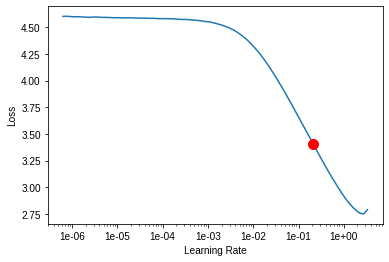

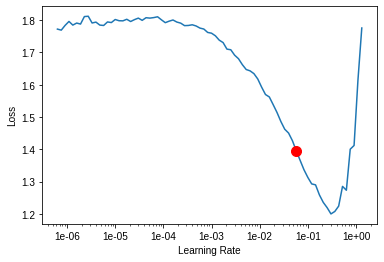

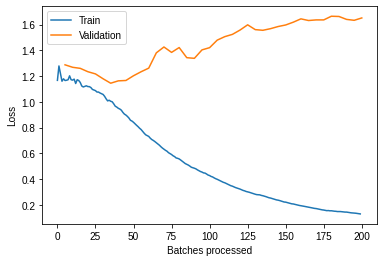

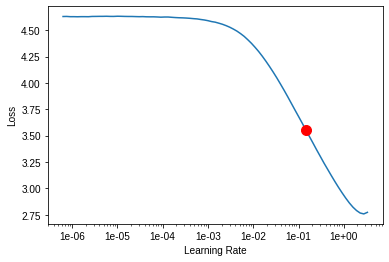

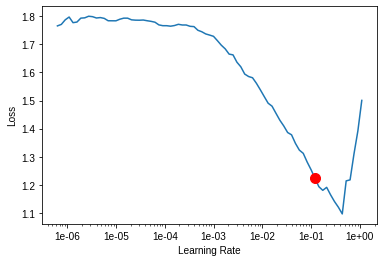

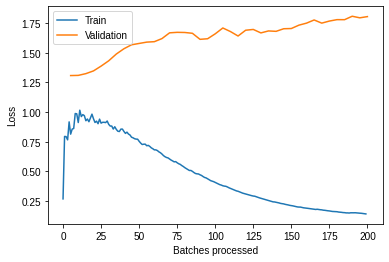

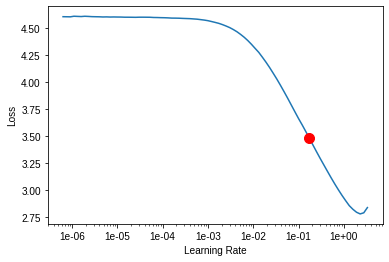

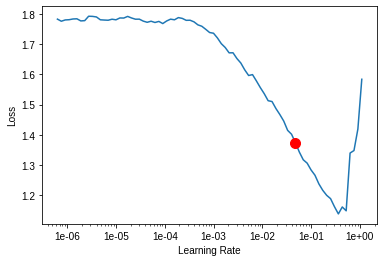

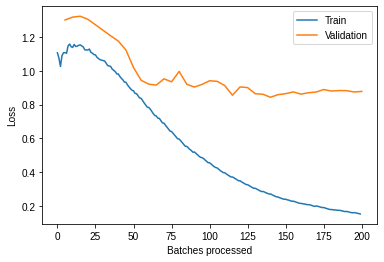

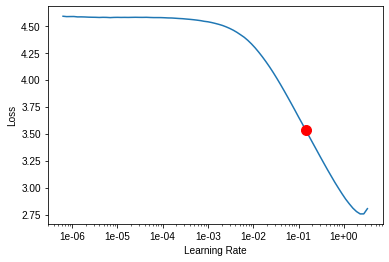

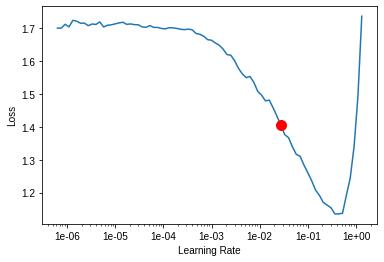

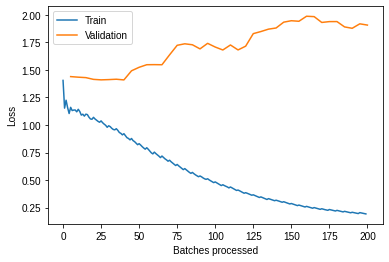

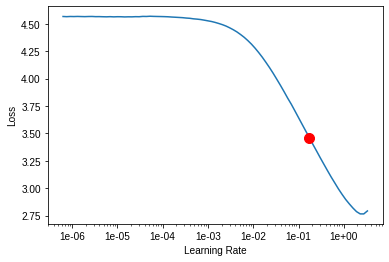

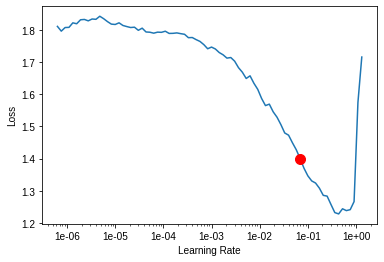

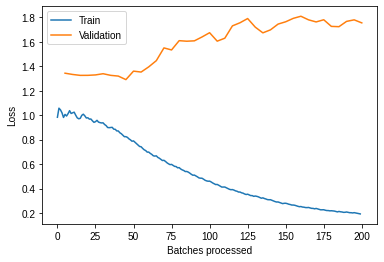

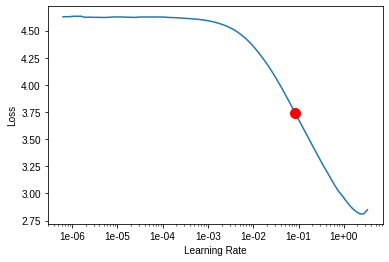

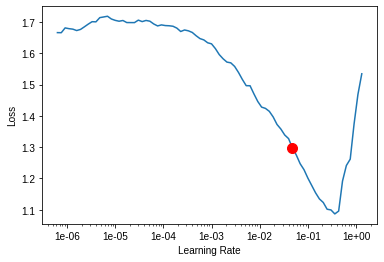

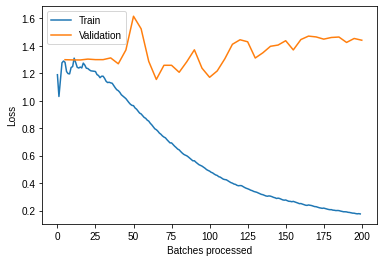

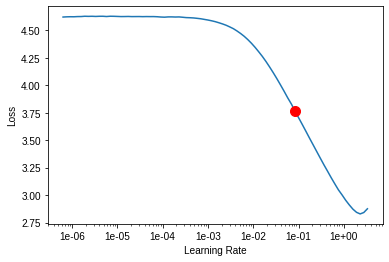

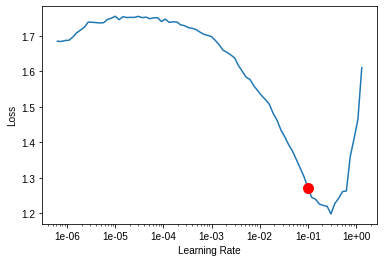

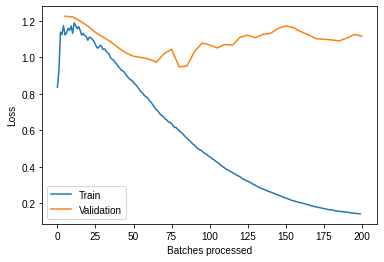

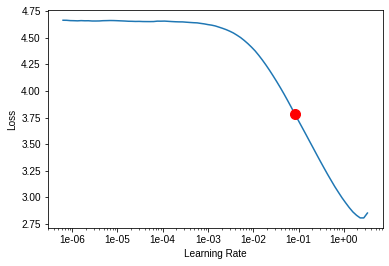

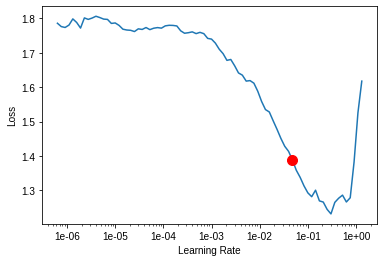

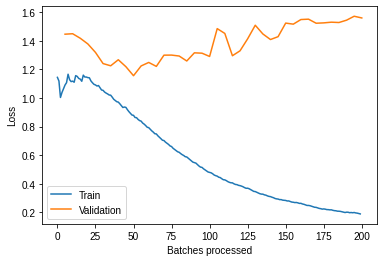

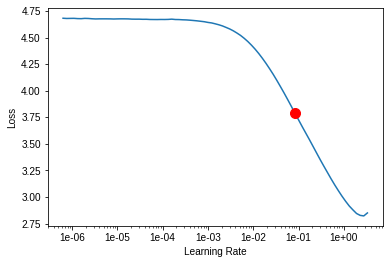

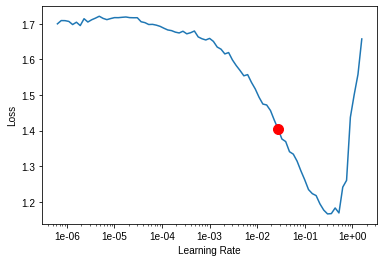

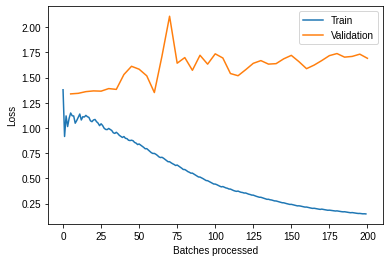

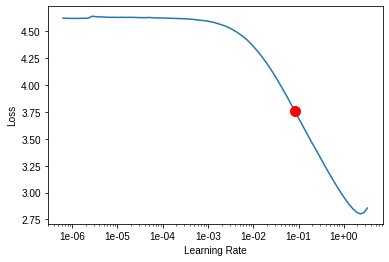

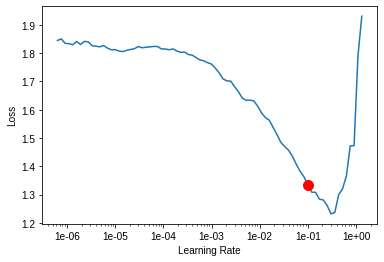

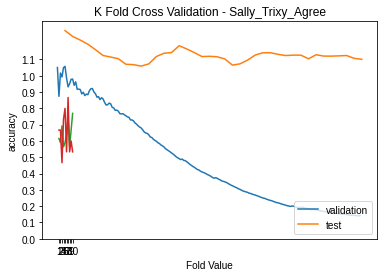

In [0]:
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, train_test_split

X = df['text'].to_numpy()
Y = df['Y'].to_numpy()

print(len(X))

n_split = 10
k_fold_val_accuracy = []
k_fold_test_accuracy = []
k_fold_noOftests = []

i = 0

for train_index, test_index in StratifiedShuffleSplit(n_split, random_state=0).split(X, Y):
#for train_index, test_index in ShuffleSplit(n_split, random_state=0).split(X):
    print("******************************************** K - Fold Cross Validation : " + str(i) +" ****************************************************************")
    i += 1
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    val_acc, test_acc = train_model_for_every_k(x_train, y_train,x_test, y_test)

    k_fold_val_accuracy.append(val_acc)
    k_fold_test_accuracy.append(test_acc)
    k_fold_noOftests.append(len(x_test))

## 10. Plotting and Saving K-Fold Cross Validation Results

K_fold Validation Accuracy for k = 5 fold :  [0.6153846383094788, 0.5897436141967773, 0.692307710647583, 0.5641025900840759, 0.5897436141967773, 0.6410256624221802, 0.7435897588729858, 0.5641025900840759, 0.6666666865348816, 0.7692307829856873]
K_fold test Accuracy for k = 5 fold :  [0.6666666666666666, 0.6666666666666666, 0.4666666666666667, 0.7333333333333333, 0.8, 0.5333333333333333, 0.8666666666666667, 0.5333333333333333, 0.6, 0.5333333333333333]


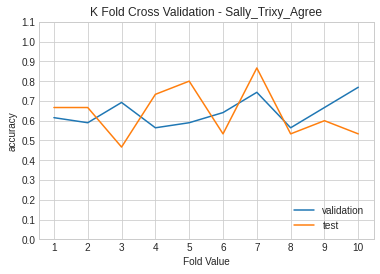

In [0]:
x = [1,2,3,4,5,6,7,8,9,10]
print("K_fold Validation Accuracy for k = 10 fold : ", k_fold_val_accuracy)
print("K_fold test Accuracy for k = 10 fold : ", k_fold_test_accuracy)

plt.plot(x, k_fold_val_accuracy)
plt.plot(x, k_fold_test_accuracy)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks(np.arange(0.0, 1.0 + 0.2, 0.10))
plt.title('K Fold Cross Validation - Sally_Trixy_Agree')
plt.ylabel('accuracy')
plt.xlabel('Fold Value')
plt.legend([ 'validation', 'test'], loc='lower right')
plt.style.use('seaborn-whitegrid')

plt.savefig("Sally_Trixy_Agree.png", dpi=1200)
plt.savefig("gdrive/My Drive/Colab Notebooks/DS_Lab/Results_ULMFit_KFold_2/Sally_Trixy_Agree.png", dpi=1200)
plt.show()

In [0]:
!rm *.pkl